# AIM: Learn and extract features with different pretext tasks

In [1]:
import numpy as np
import pandas as pd
import mne
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import F1Score, Accuracy
import random
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
import itertools
from torch.utils.data import Dataset, DataLoader, Subset
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

In [2]:
print(torch.__version__)
print(torch.backends.cudnn.version())

2.4.1
90100


In [3]:
# set working dir
print(f'Working directory is set to: {os.getcwd()}')
# path to the epoched data
data_path = r"thesis_epoched_data/EC"

Working directory is set to: /data/storage_thesis_tuur


## Functions & classes:

In [4]:
def get_participant_ids(eeg_dir, epoch_dir=False):
    """
    Function to get all participant ids from EEG data directory
    :param eeg_dir: directory where EEG data is stored
    :param epoch_dir: whether the data that we want to retrieve is from the epoch directory or from the raw EEG data directory
    :return: list of participant ids
    """
    participant_ids = []
    if epoch_dir == False:
        for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
            for file in files:
                if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                    participant_id = file.split('_')[0] # extract participant id
                    if participant_id not in participant_ids:
                        participant_ids.append(participant_id)
    else:
        participant_ids = [file.split('.')[0] for file in os.listdir(eeg_dir) if '.pt' in file]
        
    return participant_ids


def train_pretext_model(pretext_task_title,
                        pretext_task,
                        loss,
                        max_epochs,
                        data_train,
                        data_val,
                        batch_size,
                        learning_rate=0.001,
                        dropout=0.25,
                        weight_decay=0,
                        store_weights=(True, True),
                        num_extracted_features=100,
                        pretext_model='EEGNet'):
    """
    Function to train the pretext model
    :param pretext_task_title: title (string) describing the specific pretext task for saving the model weights
    :param pretext_task: pretext task (string) for correct storing of logs ['withinRP', 'acrossRP', 'acrossSub', 'contrastive_loss']
    :param loss: loss (string) for selecting the right model architecture ['soft_margin_loss', 'bce_loss', 'contrastive_loss']
    :param max_epochs: maximum number of epochs to train the model
    :param data_train: training data
    :param data_val: validation data
    :param batch_size: batch size
    :param learning_rate: learning rate
    :param dropout: dropout rate
    :param weight_decay: weight decay
    :param store_weights: whether to store the weights of the fully trained model and the best checkpoint model
    :param num_extracted_features: number of features to extract
    :param pretext_model: model to use for the pretext task (EEGNet or ShallowNet)
    :return: trained model loaded with best checkpoint
    """
    ## DEFINE THE MODEL CLASS (HAS TO BE DEFINED WITHIN THE FUNCTION TO AVOID ERRORS)
    
    ## ENCODER ARCHITECTURES (EEGNet and ShallowNet)

    # create Conv2d with max norm constraint
    class Conv2dWithConstraint(nn.Conv2d):
        def __init__(self, *args, max_norm: int = 1, **kwargs):
            self.max_norm = max_norm
            super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
            return super(Conv2dWithConstraint, self).forward(x)
        
    class EEGNet(nn.Module):
        """
        Code taken and adjusted from pytorch implementation of EEGNet
        url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
        """
        def __init__(self,
                    num_extracted_features: int = num_extracted_features, # number of features to extract  ## QUESTION
                    chunk_size: int = 1244, # number of data points in each EEG chunk
                    num_electrodes: int = 26, # number of EEG electrodes
                    F1: int = 8, # number of filters in first convolutional layer
                    F2: int = 16, # number of filters in second convolutional layer
                    D: int = 2, # depth multiplier
                    kernel_1: int = 64, # the filter size of block 1 (half of sfreq (125 Hz)) ## QUESTION 
                    kernel_2: int = 16, # the filter size of block 2 (one eight of sfreq (500 Hz)) ## QUESTION
                    dropout: float = 0.25): # dropout rate
            super(EEGNet, self).__init__()
            self.F1 = F1
            self.F2 = F2
            self.D = D
            self.chunk_size = chunk_size
            self.num_extracted_features = num_extracted_features
            self.num_electrodes = num_electrodes
            self.kernel_1 = kernel_1
            self.kernel_2 = kernel_2
            self.dropout = dropout

            self.block1 = nn.Sequential(
                nn.Conv2d(1, self.F1, (1, self.kernel_1), stride=1, padding=(0, self.kernel_1 // 2), bias=False),
                nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
                Conv2dWithConstraint(self.F1,
                                    self.F1 * self.D, (self.num_electrodes, 1),
                                    max_norm=1,
                                    stride=1,
                                    padding=(0, 0),
                                    groups=self.F1,
                                    bias=False), nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
                nn.ELU(), nn.AvgPool2d((1, 4), stride=4), nn.Dropout(p=dropout))

            self.block2 = nn.Sequential(
                nn.Conv2d(self.F1 * self.D,
                        self.F1 * self.D, (1, self.kernel_2),
                        stride=1,
                        padding=(0, self.kernel_2 // 2),
                        bias=False,
                        groups=self.F1 * self.D),
                nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
                nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3), nn.ELU(), nn.AvgPool2d((1, 8), stride=8),
                nn.Dropout(p=dropout))

            self.lin = nn.Linear(self.feature_dim(), num_extracted_features, bias=False)


        def feature_dim(self):
            # function to calculate the number of features after the convolutional blocks
            with torch.no_grad():
                mock_eeg = torch.zeros(1, 1, self.num_electrodes, self.chunk_size)

                mock_eeg = self.block1(mock_eeg)
                mock_eeg = self.block2(mock_eeg)

            return self.F2 * mock_eeg.shape[3]

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.block1(x)
            x = self.block2(x)
            x = x.flatten(start_dim=1)
            x = self.lin(x)
            return x
        
    class ShallowNet(nn.Module):
        """
        Pytorch implementation of the ShallowNet Encoder.
        Code taken and adjusted from:
        https://github.com/MedMaxLab/selfEEG/blob/024402ba4bde95051d86ab2524cc71105bfd5c25/selfeeg/models/zoo.py#L693
        """

        def __init__(self,
                    samples=1244,
                    chans=26, # number of EEG channels
                    F=40, # number of output filters in the temporal convolution layer
                    K1=25, # length of the temporal convolutional layer
                    pool=75, # temporal pooling kernel size
                    dropout=0.2, # dropout probability
                    num_extracted_features=num_extracted_features # number of features to extract
                    ):

            super(ShallowNet, self).__init__()
            self.conv1 = nn.Conv2d(1, F, (1, K1), stride=(1, 1))
            self.conv2 = nn.Conv2d(F, F, (chans, 1), stride=(1, 1))
            self.batch1 = nn.BatchNorm2d(F)
            self.pool2 = nn.AvgPool2d((1, pool), stride=(1, 15))
            self.flatten2 = nn.Flatten()
            self.drop1 = nn.Dropout(dropout)
            self.lin = nn.Linear(
                F * ((samples - K1 + 1 - pool) // 15 + 1), num_extracted_features
            )

        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.batch1(x)
            x = torch.square(x)
            x = self.pool2(x)
            x = torch.log(torch.clamp(x, 1e-7, 10000))
            x = self.flatten2(x)
            x = self.drop1(x)
            x = self.lin(x)

            return x
        
    ## CONTRASTIVE LOSS PRETEXT TASK ARCHITECTURE
        
    if pretext_model == 'EEGNet' and loss == 'contrastive_loss':
        class PretextModel(pl.LightningModule):
            def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
                super(PretextModel, self).__init__()
                self.weight_decay = weight_decay
                self.learning_rate = learning_rate
                # feature extractors
                self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
                
                # mlp projection head
                self.linear = nn.Linear(num_extracted_features, num_extracted_features)

            def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
                x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
                x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
                ## TODO: SHOULD I ADD ANOTHER LINEAR LAYER HERE FIRST?
                x1 = F.relu(x1)
                x2 = F.relu(x2)
                z1 = self.linear(x1) # forward pass through linear layer
                z2 = self.linear(x2)
                
                return z1, z2
            
            def training_step(self, train_batch, batch_idx):
                x = train_batch[0]
                y = train_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                loss = self.contrastive_loss(z1, z2, y)
                self.log('train_loss', loss, on_epoch=True, prog_bar=True)
                # self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def validation_step(self, val_batch, batch_idx):
                x = val_batch[0]
                # print(x.shape)
                y = val_batch[1]
                y = y.float()
                # print(y)
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                # print(f'{z1.shape=}')
                # print(f'{z2.shape=}')
                # print(f'{y.shape=}')
                loss = self.contrastive_loss(z1, z2, y)
                self.log('val_loss', loss, prog_bar=True, on_epoch=True)
                # self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def test_step(self, test_batch, batch_idx):
                x = test_batch[0]
                y = test_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                loss = self.contrastive_loss(z1, z2, y)
                self.log('test_loss', loss, prog_bar=True)
                # self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
                return loss
            
            def configure_optimizers(self):
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
                return optimizer
            
            def contrastive_loss(self, z1, z2, y, temperature=0.1):
                # application of NT-Xent loss https://theaisummer.com/simclr/
                batch_size = z1.shape[0]
                # first L2 normalization ## TODO: Not sure if necessary, considering already regularization with cosine_similarity
                # z1 = F.normalize(z1, p=2, dim=1)
                # z2 = F.normalize(z2, p=2, dim=1)

                representations = torch.cat([z1, z2], dim=0) # [2 X batch_size, n_features]
                similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2) # [batch_size X views, batch_size X views]

                # index positive and negative pairs
                sim_ij = torch.diag(similarity_matrix, batch_size)
                sim_ji = torch.diag(similarity_matrix, -batch_size)
                positives = torch.cat([sim_ij, sim_ji], dim=0)

                mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()
                # move mask to same device as similarity_matrix
                mask = mask.to(similarity_matrix.device)

                # exclude positive pairs from similarity matrix
                negatives = similarity_matrix * mask

                nominator = torch.exp(positives / temperature)
                denominator = torch.sum(torch.exp(negatives / temperature), dim=1)
                all_losses = -torch.log(nominator / denominator)
                loss = torch.sum(all_losses) / (2 * batch_size)
                return loss

    elif pretext_model == 'ShallowNet' and loss == 'contrastive_loss':
        class PretextModel(pl.LightningModule):
            def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
                super(PretextModel, self).__init__()
                self.weight_decay = weight_decay
                self.learning_rate = learning_rate
                # feature extractors
                self.ShallowNet = ShallowNet(num_extracted_features=num_extracted_features, dropout=dropout)
                
                # mlp projection head
                self.linear = nn.Linear(num_extracted_features, num_extracted_features)

            def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
                x1 = self.ShallowNet(x1) # forward pass through ShallowNet for first sample
                x2 = self.ShallowNet(x2) # forward pass through ShallowNet for second sample
                ## TODO: SHOULD I ADD ANOTHER LINEAR LAYER HERE FIRST?
                x1 = F.relu(x1)
                x2 = F.relu(x2)
                z1 = self.linear(x1) # forward pass through linear layer
                z2 = self.linear(x2)
                
                return z1, z2
            
            def training_step(self, train_batch, batch_idx):
                x = train_batch[0]
                y = train_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                loss = self.contrastive_loss(z1, z2, y)
                self.log('train_loss', loss, on_epoch=True, prog_bar=True)
                # self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def validation_step(self, val_batch, batch_idx):
                x = val_batch[0]
                # print(x.shape)
                y = val_batch[1]
                y = y.float()
                # print(y)
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                # print(f'{z1.shape=}')
                # print(f'{z2.shape=}')
                # print(f'{y.shape=}')
                loss = self.contrastive_loss(z1, z2, y)
                self.log('val_loss', loss, prog_bar=True, on_epoch=True)
                # self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def test_step(self, test_batch, batch_idx):
                x = test_batch[0]
                y = test_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                z1, z2 = self.forward(x1, x2)
                loss = self.contrastive_loss(z1, z2, y)
                self.log('test_loss', loss, prog_bar=True)
                # self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
                return loss
            
            def configure_optimizers(self):
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
                return optimizer
            
            def contrastive_loss(self, z1, z2, y, temperature=0.1):
                # application of NT-Xent loss https://theaisummer.com/simclr/
                batch_size = z1.shape[0]
                # first L2 normalization ## TODO: Not sure if necessary, considering already regularization with cosine_similarity
                # z1 = F.normalize(z1, p=2, dim=1)
                # z2 = F.normalize(z2, p=2, dim=1)

                representations = torch.cat([z1, z2], dim=0) # [2 X batch_size, n_features]
                similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2) # [batch_size X views, batch_size X views]

                # index positive and negative pairs
                sim_ij = torch.diag(similarity_matrix, batch_size)
                sim_ji = torch.diag(similarity_matrix, -batch_size)
                positives = torch.cat([sim_ij, sim_ji], dim=0)

                mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()
                # move mask to same device as similarity_matrix
                mask = mask.to(similarity_matrix.device)

                # exclude positive pairs from similarity matrix
                negatives = similarity_matrix * mask

                nominator = torch.exp(positives / temperature)
                denominator = torch.sum(torch.exp(negatives / temperature), dim=1)
                all_losses = -torch.log(nominator / denominator)
                loss = torch.sum(all_losses) / (2 * batch_size)
                return loss
            
    ## BCE LOSS PRETEXT TASK ARCHITECTURE

    elif pretext_model == 'EEGNet' and loss == 'bce_loss':
        class PretextModel(pl.LightningModule):
            def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
                super(PretextModel, self).__init__()
                self.weight_decay = weight_decay
                self.learning_rate = learning_rate
                # feature extractors
                self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
                
                # linear discriminate layer
                self.linear = nn.Linear(num_extracted_features, 1)

                # add metrics
                self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
                self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

            def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
                x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
                x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
                z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
                x = self.linear(z) # forward pass through linear layer
                return x
            
            def training_step(self, train_batch, batch_idx):
                x = train_batch[0]
                y = train_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('train_loss', loss, on_epoch=True, prog_bar=True)
                self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def validation_step(self, val_batch, batch_idx):
                x = val_batch[0]
                y = val_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('val_loss', loss, prog_bar=True, on_epoch=True)
                self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def test_step(self, test_batch, batch_idx):
                x = test_batch[0]
                y = test_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('test_loss', loss, prog_bar=True)
                self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
                return loss
            
            def predict_step(self, batch):
                x = batch[0]
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                return y_hat
            
            def configure_optimizers(self):
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
                return optimizer

    elif pretext_model == 'ShallowNet' and loss == 'bce_loss':
        class PretextModel(pl.LightningModule):
            def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
                super(PretextModel, self).__init__()
                self.weight_decay = weight_decay
                self.learning_rate = learning_rate
                # feature extractors
                self.ShallowNet = ShallowNet(num_extracted_features=num_extracted_features, dropout=dropout)
                
                # linear discriminate layer
                self.linear = nn.Linear(num_extracted_features, 1)

                # add metrics
                self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
                self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

            def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
                x1 = self.ShallowNet(x1) # forward pass through ShallowNet for first sample
                x2 = self.ShallowNet(x2) # forward pass through ShallowNet for second sample
                z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
                x = self.linear(z) # forward pass through linear layer
                return x
            
            def training_step(self, train_batch, batch_idx):
                x = train_batch[0]
                y = train_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('train_loss', loss, on_epoch=True, prog_bar=True)
                self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def validation_step(self, val_batch, batch_idx):
                x = val_batch[0]
                y = val_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('val_loss', loss, prog_bar=True, on_epoch=True)
                self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def test_step(self, test_batch, batch_idx):
                x = test_batch[0]
                y = test_batch[1]
                y = y.float()
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.binary_cross_entropy_with_logits(logits, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('test_loss', loss, prog_bar=True)
                self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
                return loss
            
            def predict_step(self, batch):
                x = batch[0]
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                return y_hat
            
            def configure_optimizers(self):
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
                return optimizer

    ## SOFT MARGIN LOSS PRETEXT TASK ARCHITECTURE
    if pretext_model == 'EEGNet' and loss == 'soft_margin_loss':
        class PretextModel(pl.LightningModule):
            def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
                super(PretextModel, self).__init__()
                self.weight_decay = weight_decay
                self.learning_rate = learning_rate
                # feature extractors
                self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
                
                # linear discriminate layer
                self.linear = nn.Linear(num_extracted_features, 1)

                # add metrics
                self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
                self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

            def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
                x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
                x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
                z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
                x = self.linear(z) # forward pass through linear layer
                return x
            
            def training_step(self, train_batch, batch_idx):
                x = train_batch[0]
                y = train_batch[1]
                y = y
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.soft_margin_loss(logits, y, reduce='sum')
                y = torch.where(y == -1, 0, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('train_loss', loss, on_epoch=True, prog_bar=True)
                self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def validation_step(self, val_batch, batch_idx):
                x = val_batch[0]
                y = val_batch[1]
                y = y
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.soft_margin_loss(logits, y, reduce='sum')
                y = torch.where(y == -1, 0, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('val_loss', loss, prog_bar=True, on_epoch=True)
                self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def test_step(self, test_batch, batch_idx):
                x = test_batch[0]
                y = test_batch[1]
                y = y
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.soft_margin_loss(logits, y, reduce='sum')
                y = torch.where(y == -1, 0, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('test_loss', loss, prog_bar=True)
                self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
                return loss
            
            def predict_step(self, batch):
                x = batch[0]
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                return y_hat
            
            def configure_optimizers(self):
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
                return optimizer

    if pretext_model == 'ShallowNet' and loss == 'soft_margin_loss':
        class PretextModel(pl.LightningModule):
            def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
                super(PretextModel, self).__init__()
                self.weight_decay = weight_decay
                self.learning_rate = learning_rate
                # feature extractors
                self.ShallowNet = ShallowNet(num_extracted_features=num_extracted_features, dropout=dropout)
                
                # linear discriminate layer
                self.linear = nn.Linear(num_extracted_features, 1)

                # add metrics
                self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
                self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

            def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
                x1 = self.ShallowNet(x1) # forward pass through ShallowNet for first sample
                x2 = self.ShallowNet(x2) # forward pass through ShallowNet for second sample
                z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
                x = self.linear(z) # forward pass through linear layer
                return x
            
            def training_step(self, train_batch, batch_idx):
                x = train_batch[0]
                y = train_batch[1]
                y = y
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.soft_margin_loss(logits, y, reduce='sum')
                y = torch.where(y == -1, 0, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('train_loss', loss, on_epoch=True, prog_bar=True)
                self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def validation_step(self, val_batch, batch_idx):
                x = val_batch[0]
                y = val_batch[1]
                y = y
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.soft_margin_loss(logits, y, reduce='sum')
                y = torch.where(y == -1, 0, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('val_loss', loss, prog_bar=True, on_epoch=True)
                self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
                return loss
            
            def test_step(self, test_batch, batch_idx):
                x = test_batch[0]
                y = test_batch[1]
                y = y
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                loss = F.soft_margin_loss(logits, y, reduce='sum')
                y = torch.where(y == -1, 0, y)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                self.log('test_loss', loss, prog_bar=True)
                self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
                return loss
            
            def predict_step(self, batch):
                x = batch[0]
                x1 = x[:, 0, :, :].unsqueeze(1).float()
                x2 = x[:, 1, :, :].unsqueeze(1).float()
                logits = self.forward(x1, x2)
                logits = logits.view(-1)
                y_hat = F.sigmoid(logits)
                y_hat = torch.where(y_hat > 0.5, 1, 0)
                return y_hat
            
            def configure_optimizers(self):
                optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
                return optimizer

    # remove particular warnings
    warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
    warnings.filterwarnings("ignore", ".*Trying to infer the `batch_size` from an ambiguous collection*")

    if pretext_task == 'withinRP':
        log_folder = 'withinRP_pretext_task'
    if pretext_task == 'acrossRP':
        log_folder = 'acrossRP_pretext_task'
    if pretext_task == 'acrossSub':
        log_folder = 'acrossSub_pretext_task'
    if pretext_task == 'contrastive_loss':
        log_folder = 'contrastive_loss_pretext_task'

    logger = CSVLogger("logs", name=log_folder) # log results to csv file
    torch.set_float32_matmul_precision('high') # for use of tensor cores
    # create pretext model
    model = PretextModel(learning_rate=learning_rate, dropout=dropout, weight_decay=weight_decay, num_extracted_features=num_extracted_features)
    
    # create data loaders
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
    
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

    trainer = Trainer(
        precision='16-mixed',
        accelerator='gpu',
        devices=1,
        max_epochs=max_epochs,
        callbacks=checkpoint_callback,
        enable_progress_bar=True,
        enable_model_summary=True,
        enable_checkpointing=True,
        logger=logger,
        log_every_n_steps=5,
    )

    trainer.fit(model, train_loader, val_loader)

    if store_weights[0]:
        torch.save(model.state_dict(), f'pretext_model_weights/fullytrained_{pretext_task_title}_weights.pt')
    
    # load best model checkpoint
    print(f"Best model checkpoint path: {checkpoint_callback.best_model_path}")
    best_model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path, strict=False)
    
    if store_weights[1]:
        torch.save(best_model.state_dict(), f'pretext_model_weights/{pretext_task_title}_weights.pt')

    return best_model

def plot_training_curves(metrics_path):
    """
    Function to plot training curves from csv log file
    :param metrics_path: path to the csv file containing the model diagnostics
    :return:
    """
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    metrics = pd.read_csv(metrics_path)

    # Check if 'train_f1_epoch' and 'val_f1' columns exist
    if 'train_f1_epoch' in metrics.columns and 'val_f1' in metrics.columns:
        train_f1_epoch = metrics['train_f1_epoch'].dropna()
        val_f1 = metrics['val_f1'].dropna()
        axs[0].plot(train_f1_epoch, label='Train F1 Score')
        axs[0].plot(val_f1, label='Validation F1 Score')
        axs[0].set_title('F1 Score')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('F1 Score')
        axs[0].legend()
    else:
        print("F1 score columns not found in the metrics file.")

    # Check if 'train_loss' and 'val_loss' columns exist
    if 'train_loss_epoch' in metrics.columns and 'val_loss' in metrics.columns:
        train_loss = metrics['train_loss_epoch'].dropna()
        val_loss = metrics['val_loss'].dropna()
        axs[1].plot(train_loss, label='Train Loss')
        axs[1].plot(val_loss, label='Validation Loss')
        axs[1].set_title('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
    else:
        print("Loss columns not found in the metrics file.")

    plt.tight_layout()
    plt.show()

    return

def evaluate_pretext_model(model, data_test, test_labels, pretext_task, soft_margin_loss=False, batch_size=None):
    """
    Function to evaluate the pretext model
    :param model: trained model
    :param data_test: test data
    :param test_labels: test labels
    :param pretext_task: pretext task str to select right class labels for plots ['withinRP', 'acrossRP', 'acrossSub']
    :param soft_margin_loss: whether model uses soft margin loss
    :param batch_size: batch size
    :return: test results
    """
    if batch_size is None:
        batch_size = len(data_test)
        
    # obtain predictions on test set and plot confusion matrix
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False,
                                drop_last=True)

    # model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

    trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
    trainer.test(model, test_loader)

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, test_loader)
    y_pred = np.concatenate(y_pred).flatten()
    y = np.array(test_labels)
    if soft_margin_loss:
        y = np.where(y == -1, 0, y)

    if pretext_task == 'withinRP' or pretext_task == 'acrossRP':
        class_labels = ['Separate', 'Adjacent']
    if pretext_task == 'acrossSub':
        class_labels = ['Across subjects', 'Within subject']
        
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    print('F1-score:\n', f1_score(y, y_pred, average="macro"))
    print('Accuracy:\n', (y == y_pred).sum() / len(y))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
    plt.grid(False)

    return

### Dataset classes

#### Within Subject Relative Positioning Dataset

In [5]:
class RPDataset(Dataset):
    def __init__(self, participant_ids, data_path, subsample=True, tpos=1, device='cpu', soft_margin_loss=False):
        """
        Dataset for the Relative Positioning task. Obtains all combinations of two epochs per participant.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param subsample: Whether to subsample the dataset for class balance or not
        :param tpos: Time/index difference of the epochs in which the epochs are considered adjacent
        :param device: Device to store the data ('cpu' or 'cuda')
        :param soft_margin_loss: Whether the model uses soft margin loss (needs [-1, 1] labels)
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.subsample = subsample
        self.tpos = tpos
        self.device = device
        self.soft_margin_loss = soft_margin_loss
        self.sampled_epochs_indices_id = []
        self.labels = []
        self.data_cache = {}
        self._load_data()

    def _load_data(self):
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
            # Generate all combinations of two epochs for this participant
            self.sample_all_combinations(participant_id, len(data), soft_margin_loss=self.soft_margin_loss)

    def sample_all_combinations(self, participant_id, num_epochs, soft_margin_loss=False):
        """
        Sample all combinations of two epochs for a participant
        """
        all_combinations = list(itertools.combinations(range(num_epochs), 2))
        if soft_margin_loss:
            # use -1 if the epochs are not adjacent, 1 if they are
            labels = [1 if abs(i - j) <= self.tpos else -1 for i, j in all_combinations]
        else:
            # use 0 if the epochs are not adjacent, 1 if they are
            labels = [1 if abs(i - j) <= self.tpos else 0 for i, j in all_combinations]
        if self.subsample:
            # Subsample the combinations and labels
            sampled_indices = self.subsample_combinations(labels, soft_margin_loss=self.soft_margin_loss)
        else:
            # Use all combinations
            sampled_indices = range(len(all_combinations))

        # Store the combinations and labels
        for idx in sampled_indices:
            i, j = all_combinations[idx]
            label = labels[idx]
            self.sampled_epochs_indices_id.append((participant_id, i, j, label))
            self.labels.append(label)

    def subsample_combinations(self, labels, soft_margin_loss=False):
        """
        Subsamples the combinations to ensure class balance
        """
        # Identify indices of samples with labels -1/0 and 1
        if soft_margin_loss:
            indices_0 = [idx for idx, label in enumerate(labels) if label == -1]
        else:
            indices_0 = [idx for idx, label in enumerate(labels) if label == 0]
        indices_1 = [idx for idx, label in enumerate(labels) if label == 1]

        # Determine the smaller count between the two labels
        min_count = min(len(indices_0), len(indices_1))

        # Randomly sample indices from both labels to ensure they have the same count
        np.random.seed(42)  # For reproducibility
        sampled_indices_0 = np.random.choice(indices_0, min_count, replace=False)
        sampled_indices_1 = np.random.choice(indices_1, min_count, replace=False)

        # Combine the sampled indices
        sampled_indices = np.concatenate((sampled_indices_0, sampled_indices_1))
        return sampled_indices

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id, i, j, label = self.sampled_epochs_indices_id[idx]
        data = self.data_cache[participant_id]
        sampled_epochs = data[[i, j]]
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label, participant_id

#### Across Subject Relative Positioning Dataset

In [6]:
class Across_Subject_RPDataset(Dataset):
    def __init__(self, participant_ids, data_path, subsample=True, tpos=1, device='cpu', n_samples=2, soft_margin_loss=False):
        """
        Dataset for the Relative Positioning task. Obtains n combinations of two epochs between all groups of two participants.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param subsample: Whether to subsample the dataset for class balance or not
        :param tpos: Time/index difference of the epochs in which the epochs are considered adjacent
        :param device: Device to store the data ('cpu' or 'cuda')
        :param n_samples: Number of samples for each label (adjacent/separate) to generate for each participant combination
        :param soft_margin_loss: Whether to use soft margin loss for the pretext task (needs [-1, 1] labels)
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.subsample = subsample
        self.tpos = tpos
        self.device = device
        self.n_samples = n_samples
        self.soft_margin_loss = soft_margin_loss
        self.sampled_epochs_indices_id = []
        self.data_cache = {}
        self.labels = []
        self._load_data()

    def _load_data(self):
        epoch_data = {}
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
        # Generate n combinations of two epochs between two participants
        self.sample_across_subject_combinations(self.data_cache, n=self.n_samples, soft_margin_loss=self.soft_margin_loss)
    
    def sample_across_subject_combinations(self, data_cache, n, soft_margin_loss=False):
        all_participant_combinations = list(itertools.combinations(self.participant_ids, 2)) # all combinations of participants
        warning_displayed = False  # Flag to track if the warning has been displayed

        for participant_id_1, participant_id_2 in all_participant_combinations: 
            data_1 = self.data_cache[participant_id_1]
            data_2 = self.data_cache[participant_id_2]
            num_epochs_1 = data_1.shape[0]
            num_epochs_2 = data_2.shape[0]
            # Get all combinations of indices between data_1 and data_2
            all_combinations = list(itertools.product(range(num_epochs_1), range(num_epochs_2)))
            
            # Filter combinations based on the difference between indices
            adjacent_combinations = [comb for comb in all_combinations if abs(comb[0] - comb[1]) <= self.tpos and comb[0] != comb[1]]
            separate_combinations = [comb for comb in all_combinations if abs(comb[0] - comb[1]) > self.tpos]
            # Sample n combinations from each filtered set
            sampled_adjacent_combinations = random.sample(adjacent_combinations,
                                                        min(n, len(adjacent_combinations)))
            sampled_separate_combinations = random.sample(separate_combinations,
                                                     min(n, len(separate_combinations)))
            
            if n > len(adjacent_combinations) and not warning_displayed:
                print(f"Warning: asking for {n} adjacent samples, but only {len(adjacent_combinations)} adjacent samples available between two participants.")
                print("This will result in class imbalance.")
                warning_displayed = True  # Set the flag to True after displaying the warning

            # Store the combinations and labels
            for i, j in sampled_adjacent_combinations:
                self.sampled_epochs_indices_id.append((participant_id_1, participant_id_2, i, j, 1))
                self.labels.append(1)
            if soft_margin_loss:
                for i, j in sampled_separate_combinations:
                    self.sampled_epochs_indices_id.append((participant_id_1, participant_id_2, i, j, -1))
                    self.labels.append(-1)
            else:
                for i, j in sampled_separate_combinations:
                    self.sampled_epochs_indices_id.append((participant_id_1, participant_id_2, i, j, 0))
                    self.labels.append(0)

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id_1, participant_id_2, i, j, label = self.sampled_epochs_indices_id[idx]
        # Load the data for the participant on-the-fly
        data_1 = self.data_cache[participant_id_1]
        data_2 = self.data_cache[participant_id_2]
        epoch_1 = data_1[i]
        epoch_2 = data_2[j]
        sampled_epochs = torch.stack([epoch_1, epoch_2])
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label

#### Across Subject Dataset

In [7]:
class Across_Subject_Dataset(Dataset):
    def __init__(self, participant_ids, data_path, device='cpu', n_samples=2, soft_margin_loss=False):
        """
        Dataset for the across subject task. Obtains n combinations of two epochs within a participant and between participants.
        And learns to predict if the two epochs are from the same participant or not.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param device: Device to store the data ('cpu' or 'cuda')
        :param n_samples: Number of samples for each label (adjacent/separate) to generate for each participant combination
        :param soft_margin_loss: Whether to use soft margin loss or not (needs [-1, 1] labels)
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.device = device
        self.n_samples = n_samples
        self.soft_margin_loss = soft_margin_loss
        self.sampled_epochs_indices_id = []
        self.data_cache = {}
        self.labels = []
        self._load_data()

    def _load_data(self):
        epoch_data = {}
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
        # Generate n combinations of two epochs between two participants
        self.sample_epochs_combinations(self.data_cache, n=self.n_samples, soft_margin_loss=self.soft_margin_loss)
    
    def sample_epochs_combinations(self, data_cache, n, soft_margin_loss=False):
        for participant in data_cache.keys():
            data = data_cache[participant]
            n_epochs = data.shape[0]

            # sample n pairs of epochs from the same participant
            within_subject_combos = [comb for comb in itertools.combinations(range(n_epochs), 2)]

            # adjust n if there are not enough within subject samples
            if n > len(within_subject_combos):
                print(f"Warning: asking for {n} within subject samples, but only {len(within_subject_combos)} within subject samples available within participant {participant}.")
                print(f"{len(within_subject_combos)} will be sampled instead of {n}.")
                adj_n = len(within_subject_combos)
            else:
                adj_n = n

            for i, j in random.sample(within_subject_combos, adj_n): # ensure that the same pair is not sampled twice
                self.sampled_epochs_indices_id.append((participant, participant, i, j, 1))
                self.labels.append(1)
            
            # sample n pairs of epochs from the participant and another participant
            for other_participant in random.sample([p for p in data_cache.keys() if p != participant], adj_n):
                other_n_epochs = data_cache[other_participant].shape[0]
                between_subject_combos = list(itertools.product(range(n_epochs), range(other_n_epochs)))
                i, j = random.choice(between_subject_combos)
                if soft_margin_loss:
                    self.sampled_epochs_indices_id.append((participant, other_participant, i, j, -1))  
                    self.labels.append(-1)
                else:
                    self.sampled_epochs_indices_id.append((participant, other_participant, i, j, 0))  
                    self.labels.append(0)
            
            # delete variables to free up memory
            del within_subject_combos
            del between_subject_combos

        return

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id_1, participant_id_2, i, j, label = self.sampled_epochs_indices_id[idx]
        # Load the data for the participant on-the-fly
        if participant_id_1 == participant_id_2:
            data = self.data_cache[participant_id_1]
            sampled_epochs = torch.stack([data[i], data[j]])
        if participant_id_1 != participant_id_2:
            data_1 = self.data_cache[participant_id_1]
            data_2 = self.data_cache[participant_id_2]
            epoch_1 = data_1[i]
            epoch_2 = data_2[j]
            sampled_epochs = torch.stack([epoch_1, epoch_2])
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label

#### Contrastive Loss Dataset

In [8]:
class Contrastive_Loss_Dataset(Dataset):
    def __init__(self, participant_ids, data_path, device='cpu', n_samples=1):
        """
        Dataset for the pretext task with contrastive loss and neurologist recommended augmentations. 
        For each participant samples n epochs on which two random augmentations are applied.
        The samples are then used to learn to predict if two augmentations were derived from the same original epoch,
        or two different epochs.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param device: Device to store the data ('cpu' or 'cuda')
        :param n_samples: Number of epochs to sample from each participant
        :param neg_samples: Number of negative samples to create for each positive sample
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.device = device
        self.n_samples = n_samples
        self.sampled_epochs_indices_id = []
        self.data_cache = {}
        self.labels = []
        self._load_data()

        self.available_augmentations = {
            "amplitude_scale": [0.5, 2], 
            "time_shift": [-50, 50], 
            "DC_shift": [-10, 10], 
            "zero-masking": [0, 150], 
            "additive_Gaussian_noise": [0, 0.2], 
            "band-stop_filter": [2.8, 61], # max is nyquist frequency
        }

        self.NUM_AUGMENTATIONS = 1 # number of augmentations to apply to each epoch
        self.TEMPORAL_LEN = 1244 # length of the EEG signal
        self.SFREQ = 125 # sampling frequency of the EEG signal ## QUESTION: SHOULD I USE ORIGINAL SFREQ OR DOWNSAMPLED 125 HZ

    def _load_data(self):
        epoch_data = {}
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
        # sample n epochs from each participant
        self.sample_epochs(self.data_cache, n=self.n_samples)
    
    def sample_epochs(self, data_cache, n):
        for participant in data_cache.keys():
            data = data_cache[participant]
            n_epochs = data.shape[0]
            sampled_epochs_indices = random.sample(range(n_epochs), n)
            for sampled_epoch_idx in sampled_epochs_indices:
                self.sampled_epochs_indices_id.append((participant, sampled_epoch_idx))
        return
    
    def get_augmentation_set(self):
        # taken and adjusted from https://github.com/zacharycbrown/ssl_baselines_for_biosignal_feature_extraction/blob/main/data_loaders.py#L535
        augmentation_set = []
        selected_augmentations = random.sample(list(self.available_augmentations.keys()), self.NUM_AUGMENTATIONS)
        assert len(selected_augmentations) == self.NUM_AUGMENTATIONS

        for aug in selected_augmentations:
            if aug in ['amplitude_scale', 'DC_shift', 'additive_Gaussian_noise', 'band-stop_filter']: # augmentation that requires float val
                aug_param = random.uniform(self.available_augmentations[aug][0], self.available_augmentations[aug][1])
            elif aug in ['time_shift', 'zero-masking']: # augmentation that requires int val
                aug_param = random.randint(self.available_augmentations[aug][0], self.available_augmentations[aug][1])
                if aug == 'zero-masking':
                    aug_param = [aug_param, random.randint(0, self.TEMPORAL_LEN-1)]
            else:
                raise NotImplementedError(f"Augmentation {aug} not implemented")
            
            if aug == 'band-stop_filter': # somehow getting a value higher than given range
                if aug_param > 61:
                    print(f'band_stop_filter: {aug_param=}')
            augmentation_set.append((aug, aug_param))
        return augmentation_set
            
    def apply_augmentation(self, sampled_epoch, augmentation):
        # apply augmentation to the sampled epoch with shape [n_channels, n_samples] ## QUESTION: IN CASE OF MULTIPLE AUGMENTATIONS WHICH FIRST?
        for aug in augmentation: # apply each augmentation
            if aug[0] == 'amplitude_scale':
                sampled_epoch = sampled_epoch * aug[1]

            elif aug[0] == 'time_shift':
                sampled_epoch = torch.roll(sampled_epoch, aug[1], dims=1)

            elif aug[0] == 'DC_shift':
                sampled_epoch = sampled_epoch + aug[1]

            elif aug[0] == 'zero-masking':
                sampled_epoch[:, aug[1][0]:aug[1][1]] = 0

            elif aug[0] == 'additive_Gaussian_noise':
                sampled_epoch = sampled_epoch + torch.randn_like(sampled_epoch) * aug[1]

            elif aug[0] == 'band-stop_filter':
                # Convert to NumPy array for notch_filter
                sampled_epoch_np = sampled_epoch.cpu().numpy()
                filtered_epoch_np = mne.filter.notch_filter(sampled_epoch_np, Fs=self.SFREQ, freqs=aug[1])
                # Convert back to PyTorch tensor
                sampled_epoch = torch.tensor(filtered_epoch_np, device=self.device)

            else:
                raise NotImplementedError(f"Augmentation {aug[0]} not implemented")
        augmented_epoch = sampled_epoch
        return augmented_epoch # shape [n_channels, n_samples]

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id, i = self.sampled_epochs_indices_id[idx]
        data = self.data_cache[participant_id]
        sampled_epoch = data[i]
        # create positive pair
        augmentation_set_1 = self.get_augmentation_set()
        augmentation_set_2 = self.get_augmentation_set()
        augmented_epoch_1 = self.apply_augmentation(sampled_epoch, augmentation_set_1)
        augmented_epoch_2 = self.apply_augmentation(sampled_epoch, augmentation_set_2)
        augmented_epochs = torch.stack([augmented_epoch_1, augmented_epoch_2]) # shape [2, n_channels, n_samples]
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(augmented_epochs, np.ndarray):
            augmented_epochs = torch.tensor(augmented_epochs)
        # Transfer data to GPU in batches
        augmented_epochs = augmented_epochs.to(self.device)
        # Create a positive pair (label 1)
        positive_pair = (augmented_epochs, torch.tensor(1.0, device=self.device))

        return positive_pair

# Training pretext models

## 2. Across Subject RP

### 2a. Tpos = 1

#### Data loading & splitting

In [9]:
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 5)
# separate replication set here, because otherwise combinations between replication and training set would be possible
replication_ids = [par_id for par_id in participant_ids if par_id.startswith('sub-19')] 
training_ids = [par_id for par_id in participant_ids if not par_id.startswith('sub-19')]
test_dataset = Across_Subject_RPDataset(replication_ids, data_path, subsample=True, device='cuda', tpos=1, n_samples=1, soft_margin_loss=True)
train_dataset = Across_Subject_RPDataset(training_ids, data_path, subsample=True, device='cuda', tpos=1, n_samples=1, soft_margin_loss=True)

print(np.unique(train_dataset.labels, return_counts=True))
print(len(train_dataset))
print(train_dataset[0][0].shape)

/tmp/ipykernel_1302299/1022595633.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))


(array([-1,  1]), array([646953, 646953]))
1293906
torch.Size([2, 26, 1244])


In [10]:
# split train into train/validation set

groups = [f"{pair[0]}_{pair[1]}" for pair in train_dataset.sampled_epochs_indices_id]
labels = train_dataset.labels


# Assuming trainval_indices is a list of indices for the train dataset
trainval_indices = list(range(len(labels)))

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# obtain actual train, val, test splits
# Create subsets using the indices
data_train = Subset(train_dataset, train_indices)
data_val = Subset(train_dataset, val_indices)

# Print dataset sizes and label distributions
train_labels = [train_dataset.labels[i] for i in train_indices]
val_labels = [train_dataset.labels[i] for i in val_indices]

del groups
del labels

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(test_dataset)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_dataset.labels, return_counts=True)}")

Train: 1035124, Val: 258782, Test: 11130
Train: (array([-1,  1]), array([517562, 517562]))
Val: (array([-1,  1]), array([129391, 129391]))
Test: (array([-1,  1]), array([5565, 5565]))


#### Training pretext model

In [11]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task_title='acrossRP_tpos1_ShallowNet_pretext_model',
    pretext_task='acrossRP',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True),
    pretext_model='ShallowNet',
    loss='soft_margin_loss',
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | ShallowNet | ShallowNet        | 350 K  | train
1 | linear     | Linear            | 101    | train
2 | train_f1   | MulticlassF1Score | 0      | train
3 | val_f1     | MulticlassF1Score | 0      | train
---------------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.404     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs/acrossRP_pretext_task/version_0/checkpoints/epoch=0-train_loss=0.73-train_f1=0.46-val_loss=0.70-val_f1=0.40.ckpt


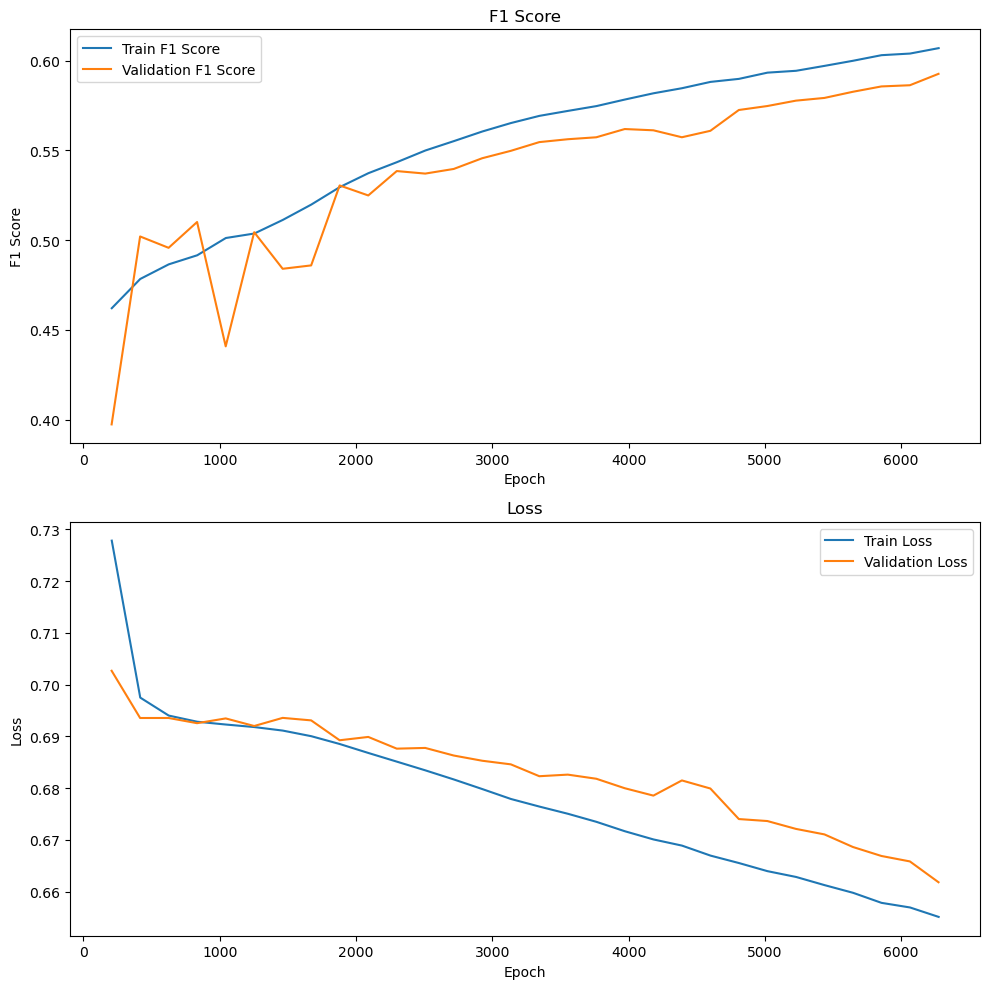

In [12]:
# plot training curves
plot_training_curves('logs/acrossRP_pretext_task/version_0/metrics.csv')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.3985150158405304     │
│         test_loss         │    0.7016462683677673     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


classification report:
               precision    recall  f1-score   support

    Separate       0.50      0.91      0.64      5565
    Adjacent       0.50      0.09      0.15      5565

    accuracy                           0.50     11130
   macro avg       0.50      0.50      0.40     11130
weighted avg       0.50      0.50      0.40     11130

F1-score:
 0.39896827853334305
Accuracy:
 0.49928122192273133


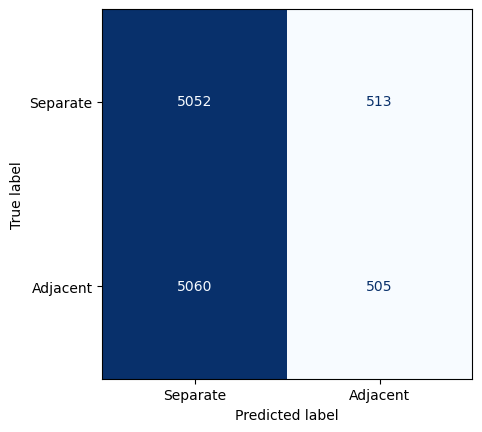

In [13]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, pretext_task='acrossRP', batch_size=500, soft_margin_loss=True)

In [14]:
# clear GPU memory after training the model
del train_dataset
del test_dataset
del data_train
del data_val
torch.cuda.empty_cache()

### 2b. Tpos = 2

#### Data loading & splitting

In [15]:
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 5)
# separate replication set here, because otherwise combinations between replication and training set would be possible
replication_ids = [par_id for par_id in participant_ids if par_id.startswith('sub-19')] 
training_ids = [par_id for par_id in participant_ids if not par_id.startswith('sub-19')]
test_dataset = Across_Subject_RPDataset(replication_ids, data_path, subsample=True, device='cuda', tpos=2, n_samples=1, soft_margin_loss=True)
train_dataset = Across_Subject_RPDataset(training_ids, data_path, subsample=True, device='cuda', tpos=2, n_samples=1, soft_margin_loss=True)

print(np.unique(train_dataset.labels, return_counts=True))
print(len(train_dataset))
print(train_dataset[0][0].shape)

/tmp/ipykernel_1302299/1022595633.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))


(array([-1,  1]), array([646953, 646953]))
1293906
torch.Size([2, 26, 1244])


In [16]:
# split train into train/validation set

groups = [f"{pair[0]}_{pair[1]}" for pair in train_dataset.sampled_epochs_indices_id]
labels = train_dataset.labels


# Assuming trainval_indices is a list of indices for the train dataset
trainval_indices = list(range(len(labels)))

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# obtain actual train, val, test splits
# Create subsets using the indices
data_train = Subset(train_dataset, train_indices)
data_val = Subset(train_dataset, val_indices)

# Print dataset sizes and label distributions
train_labels = [train_dataset.labels[i] for i in train_indices]
val_labels = [train_dataset.labels[i] for i in val_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(test_dataset)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_dataset.labels, return_counts=True)}")

Train: 1035124, Val: 258782, Test: 11130
Train: (array([-1,  1]), array([517562, 517562]))
Val: (array([-1,  1]), array([129391, 129391]))
Test: (array([-1,  1]), array([5565, 5565]))


#### Training pretext model

In [17]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task_title='acrossRP_tpos2_ShallowNet_pretext_model',
    pretext_task='acrossRP',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True),
    pretext_model='ShallowNet',
    loss='soft_margin_loss',
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | ShallowNet | ShallowNet        | 350 K  | train
1 | linear     | Linear            | 101    | train
2 | train_f1   | MulticlassF1Score | 0      | train
3 | val_f1     | MulticlassF1Score | 0      | train
---------------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.404     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs/acrossRP_pretext_task/version_1/checkpoints/epoch=0-train_loss=0.72-train_f1=0.46-val_loss=0.72-val_f1=0.40.ckpt


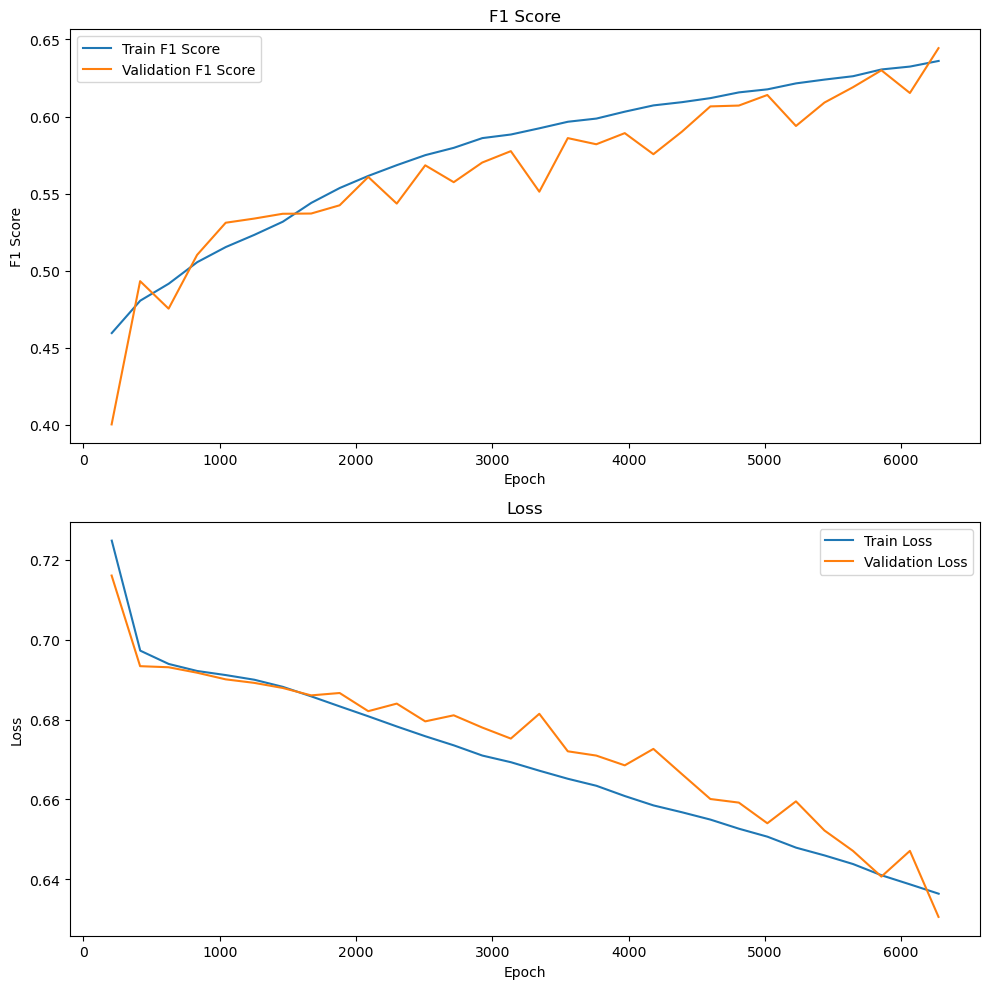

In [18]:
# plot training curves
plot_training_curves('logs/acrossRP_pretext_task/version_1/metrics.csv')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.39856329560279846    │
│         test_loss         │    0.7119454741477966     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


classification report:
               precision    recall  f1-score   support

    Separate       0.50      0.09      0.15      5565
    Adjacent       0.50      0.91      0.65      5565

    accuracy                           0.50     11130
   macro avg       0.50      0.50      0.40     11130
weighted avg       0.50      0.50      0.40     11130

F1-score:
 0.3989304556220847
Accuracy:
 0.5000898472596585


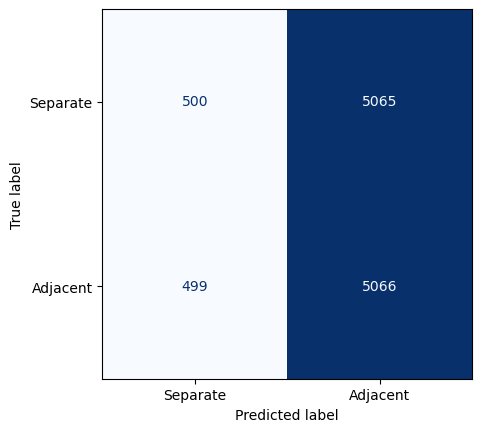

In [19]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, pretext_task='acrossRP', batch_size=500, soft_margin_loss=True)

In [20]:
# clear GPU memory after training the model
del train_dataset
del test_dataset
del data_train
del data_val
torch.cuda.empty_cache()

### 2c. Tpos = 4

#### Data loading & splitting

In [21]:
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 5)
# separate replication set here, because otherwise combinations between replication and training set would be possible
replication_ids = [par_id for par_id in participant_ids if par_id.startswith('sub-19')] 
training_ids = [par_id for par_id in participant_ids if not par_id.startswith('sub-19')]
test_dataset = Across_Subject_RPDataset(replication_ids, data_path, subsample=True, device='cuda', tpos=4, n_samples=1, soft_margin_loss=True)
train_dataset = Across_Subject_RPDataset(training_ids, data_path, subsample=True, device='cuda', tpos=4, n_samples=1, soft_margin_loss=True)

print(np.unique(train_dataset.labels, return_counts=True))
print(len(train_dataset))
print(train_dataset[0][0].shape)

/tmp/ipykernel_1302299/1022595633.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))


(array([-1,  1]), array([646953, 646953]))
1293906
torch.Size([2, 26, 1244])


In [22]:
# split train into train/validation set

groups = [f"{pair[0]}_{pair[1]}" for pair in train_dataset.sampled_epochs_indices_id]
labels = train_dataset.labels


# Assuming trainval_indices is a list of indices for the train dataset
trainval_indices = list(range(len(labels)))

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# obtain actual train, val, test splits
# Create subsets using the indices
data_train = Subset(train_dataset, train_indices)
data_val = Subset(train_dataset, val_indices)

# Print dataset sizes and label distributions
train_labels = [train_dataset.labels[i] for i in train_indices]
val_labels = [train_dataset.labels[i] for i in val_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(test_dataset)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_dataset.labels, return_counts=True)}")

Train: 1035124, Val: 258782, Test: 11130
Train: (array([-1,  1]), array([517562, 517562]))
Val: (array([-1,  1]), array([129391, 129391]))
Test: (array([-1,  1]), array([5565, 5565]))


#### Training pretext model

In [23]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task_title='acrossRP_tpos4_ShallowNet_pretext_model',
    pretext_task='acrossRP',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True),
    pretext_model='ShallowNet',
    loss='soft_margin_loss',
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | ShallowNet | ShallowNet        | 350 K  | train
1 | linear     | Linear            | 101    | train
2 | train_f1   | MulticlassF1Score | 0      | train
3 | val_f1     | MulticlassF1Score | 0      | train
---------------------------------------------------------
350 K     Trainable params
0         Non-trainable params
350 K     Total params
1.404     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs/acrossRP_pretext_task/version_2/checkpoints/epoch=0-train_loss=0.72-train_f1=0.47-val_loss=0.70-val_f1=0.47.ckpt


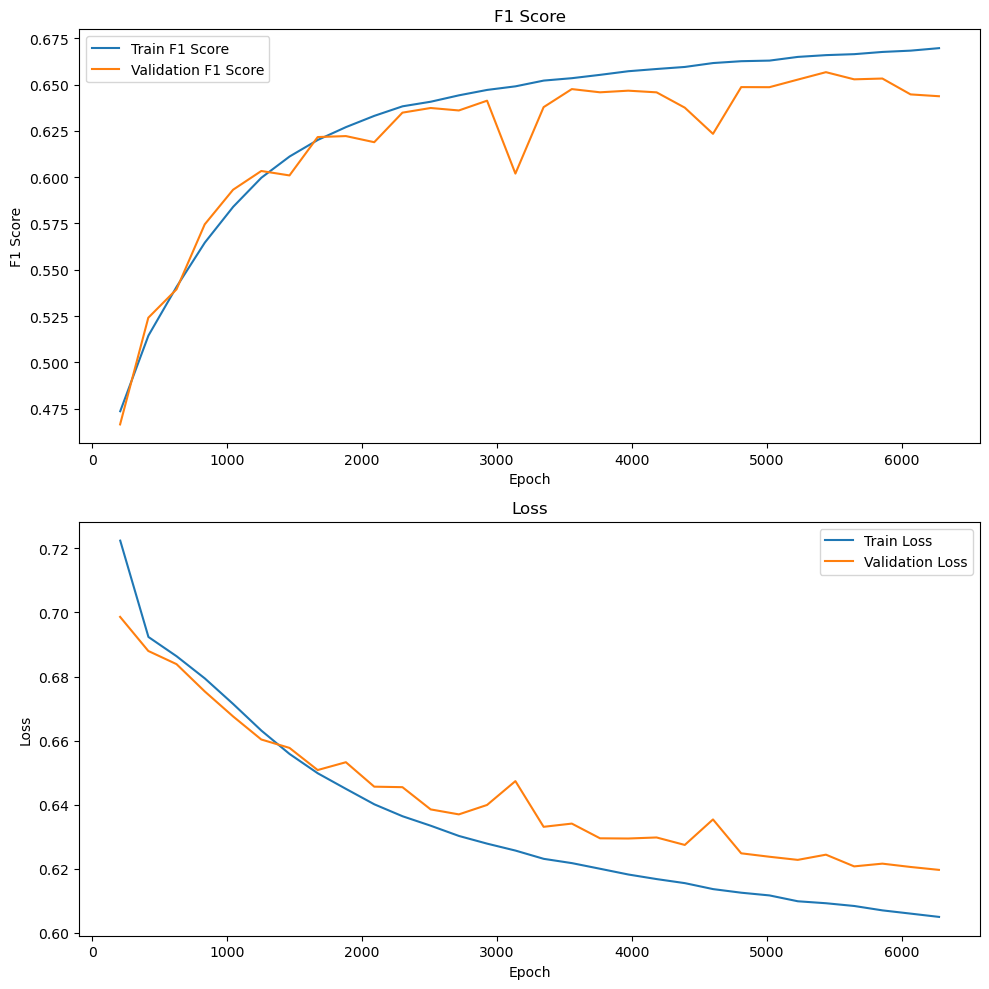

In [24]:
# plot training curves
plot_training_curves('logs/acrossRP_pretext_task/version_2/metrics.csv')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.45754295587539673    │
│         test_loss         │    0.7010733485221863     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


classification report:
               precision    recall  f1-score   support

    Separate       0.50      0.75      0.60      5565
    Adjacent       0.49      0.24      0.32      5565

    accuracy                           0.49     11130
   macro avg       0.49      0.49      0.46     11130
weighted avg       0.49      0.49      0.46     11130

F1-score:
 0.45878270279427436
Accuracy:
 0.4945193171608266


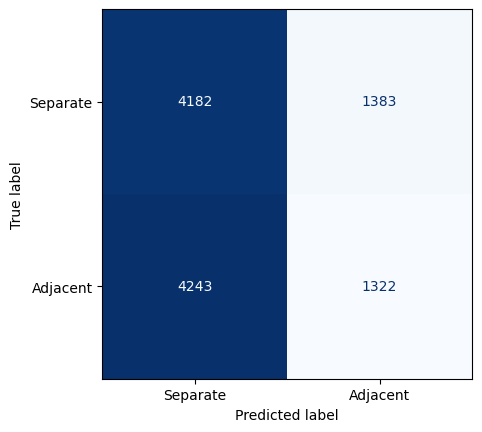

In [25]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, pretext_task='acrossRP', batch_size=500, soft_margin_loss=True)

In [26]:
# clear GPU memory after training the model
del train_dataset
del test_dataset
del data_train
del data_val
torch.cuda.empty_cache()